In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [2]:
def exponentialdecay_testing():
    #generation of data for testing
    x_axis = np.linspace(1, 51, 20)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 100)
    
    mod, params = fitlogic.make_decayexponential_model()
    print('Parameters of the model', mod.param_names, ' with the independet variable', mod.independent_vars)

    params['amplitude'].value = -100 + abs(np.random.normal(0,200))
    params['lifetime'].value = 1 + abs(np.random.normal(0,20))
    params['offset'].value = 1 + abs(np.random.normal(0, 200))
    print('\n',
          'amplitude', params['amplitude'].value, '\n',
          'lifetime', params['lifetime'].value, '\n',
          'offset', params['offset'].value)

    data_noisy = (mod.eval(x=x_axis, params=params) + 10* np.random.normal(size=x_axis.shape))
    
    result = fitlogic.make_decayexponential_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_decayexponential)
    
    data = data_noisy
    offset = data[-max(1,int(len(x_axis)/10)):].mean()

    #substraction of offset
    if data[0]<data[-1]:
        data_level = offset - data
    else:
        data_level = data - offset
    for i in range(0, len(x_axis)):
        if data_level[i] <= data_level.std():
            break
    print(i)
    
    try:
        data_level_log = np.log(data_level[0:i])
        linear_result = fitlogic.make_linear_fit(
            axis=x_axis[0:i],
            data=data_level_log,
            estimator=fitlogic.estimate_linear)
        plt.plot(x_axis[0:i], data_level_log, 'ob')
        plt.plot(x_axis[0:i], linear_result.best_fit,'-r')
        plt.plot(x_axis[0:i], linear_result.init_fit,'-y')
        plt.show()
    except:
        plt.plot(x_axis, np.log(data_level), 'or')
        plt.show()
        print("linear fitting poorly conditioned")
        
    plt.plot(x_axis, data_noisy, 'ob')
    plt.plot(x_nice, mod.eval(x=x_nice, params=params), '-g')
    print(result.fit_report())
    plt.plot(x_axis, result.init_fit, '-y', linewidth=2.0)
    plt.plot(x_axis, result.best_fit, '-r', linewidth=2.0)
    plt.show()


Parameters of the model ['amplitude', 'beta', 'lifetime', 'offset']  with the independet variable x

 amplitude -26.14144097639148 
 lifetime 9.925514602453495 
 offset 123.41944728920879
2
linear fitting poorly conditioned
[[Model]]
    ((Model(amplitude_function) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 35
    # data points      = 20
    # variables        = 3
    chi-square         = 2435.618
    reduced chi-square = 143.272
    Akaike info crit   = 102.044
    Bayesian info crit = 105.032
[[Variables]]
    amplitude:  -63.1730628 +/- 161.0366 (254.91%) (init= 55.45247)
    beta:        1 (fixed)
    lifetime:    79.8270430 +/- 287.5368 (360.20%) (init= 44.73684)
    offset:      162.148691 +/- 166.6763 (102.79%) (init= 126.1049)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, offset)         = -0.999 
    C(lifetime, offset)          =  0.996 
    C(amplitude, lifetime)       = 

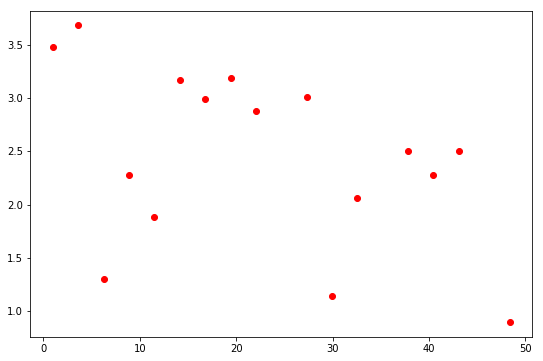

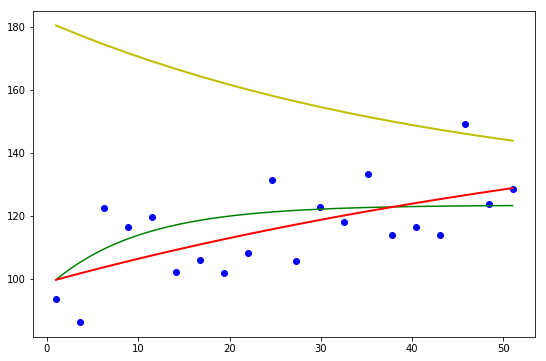

In [3]:
exponentialdecay_testing()

In [11]:
def bareexponentialdecay_testing():
    #generation of data for testing
    x_axis = np.linspace(1, 51, 20)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 100)

    mod, params = fitlogic.make_bareexponentialdecay_model()
    print('Parameters of the model', mod.param_names,
          ' with the independet variable', mod.independent_vars)

    params['lifetime'].value = 1 + abs(np.random.normal(0,25))
    print('\n''lifetime', params['lifetime'].value)

    data_noisy = (mod.eval(x=x_axis, params=params) + 0.125 * np.random.normal(size=x_axis.shape))
    data = abs(data_noisy)

    nice_data = mod.eval(x=x_nice, params=params)

    for i in range(0, len(x_axis)):
        if data[i] <= data.std():
            break

    offset = data_noisy.min()

    leveled_data = data_noisy - offset

    plt.figure()
    plt.plot(x_nice, nice_data, label='ref exp. decay data no offest')
    plt.plot(x_nice, nice_data+1, label='ref exp. decay data +1 offset')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.,
               prop={'size':12}, title='ref nice data')
    plt.show()

    plt.figure()
    plt.plot(x_nice, np.log(nice_data), label='ref exp. decay data no offest, log')
    plt.plot(x_nice, np.log(nice_data+1), label='ref exp. decay data +1 offset, log')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.,
               prop={'size':12}, title='ref nice data, log')
    plt.show()


    data_log = np.log(leveled_data)

    linear_result = fitlogic.make_linear_fit(
        x_axis=x_axis,
        data=data_log,
        estimator=fitlogic.estimate_linear)
    
    plt.figure()
    plt.plot(x_axis, data_log, 'ob', label='logarithmic data')
    plt.plot(x_axis, linear_result.best_fit,'-r', label='best fit')
    plt.plot(x_axis, linear_result.init_fit,'-y', label='initial fit')
    plt.xlabel('Time x')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    result = fitlogic.make_decayexponential_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_decayexponential)
    
    print(result.fit_report())

    plt.figure()
    plt.plot(x_axis, data_noisy, 'ob',label='noisy data')
    plt.plot(x_nice, mod.eval(x=x_nice, params=params), '-g', label='simulated data')
    plt.plot(x_axis, result.init_fit, '-y', linewidth=1.0, label='initial values')
    plt.plot(x_axis, result.best_fit, '-r', linewidth=1.0, label='best fit')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.xlabel('Time x')
    plt.ylabel('signal')
    plt.show()

Parameters of the model ['beta', 'lifetime']  with the independet variable x

lifetime 21.10881237240778


Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-6c04e507198b>", line 1, in <module>
    bareexponentialdecay_testing()
  File "<ipython-input-11-b4fbad754865>", line 48, in bareexponentialdecay_testing
    estimator=fitlogic.estimate_linear)
  File "/home/jan/qo/qudi/logic/fitmethods/linearmethods.py", line 215, in make_linear_fit
    result = linear.fit(data, x=x_axis, params=params)
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 541, in fit
    output.fit(data=data, weights=weights)
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 747, in fit
    _ret = self.minimize(method=self.method)
  File "/usr/lib/python3/dist-packages/lmfit/minimizer.py", line 1242, in minimize
    return function(**kwargs)
  File "/usr/lib/python3/dist-packages/lmfit/minimizer.py", line 1072, in leastsq
    lsout = scipy_leastsq(self._

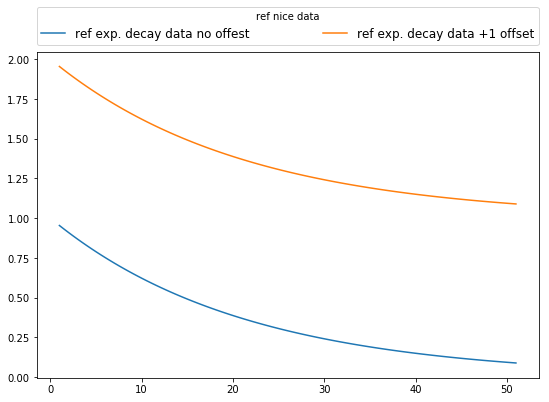

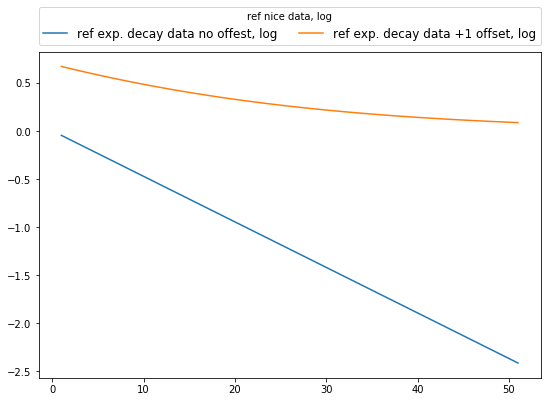

In [12]:
bareexponentialdecay_testing()

In [17]:
def stretchedexponentialdecay_testing():
    x_axis = np.linspace(0, 51, 100)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 100)

    mod, params = fitlogic.make_decayexponentialstretched_model()
    print('Parameters of the model', mod.param_names,
          ' with the independet variable', mod.independent_vars)

    params['beta'].value = 2 + abs(np.random.normal(0,0.5))
    params['amplitude'].value = 10 #- abs(np.random.normal(0,20))
    params['lifetime'].value =1 + abs(np.random.normal(0,30))
    params['offset'].value = 1 + abs(np.random.normal(0, 20))
    print('\n', 'amplitude', params['amplitude'].value, '\n', 'lifetime',
          params['lifetime'].value,'\n', 'offset', params['offset'].value,'\n',
          'beta', params['beta'].value)

    data_noisy = (mod.eval(x=x_axis, params=params) + 1.5* np.random.normal(size=x_axis.shape))

    result = fitlogic.make_decayexponentialstretched_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_decayexponentialstretched)

    data = data_noisy
    #calculation of offset
    offset = data[-max(1,int(len(x_axis)/10)):].mean()
    if data[0]<data[-1]:
        params['amplitude'].max = 0-data.std()
        data_sub = offset - data
    else:
        params['amplitude'].min = data.std()
        data_sub = data-offset

    amplitude = (data_sub.max()
                 - data_sub[-max(1, int(len(x_axis)/10)):].mean() 
                 - data_sub[-max(1,int(len(x_axis)/10)):].std())
    
    data_level = data_sub / amplitude

    a = 0
    b = len(data_sub)
    for i in range(0,len(data_sub)):
        if data_level[i]>=1:
            a=i+1
        if data_level[i] <=data_level.std():
            b=i
            break
    print(a,b)

    try:
        double_lg_data = np.log(-np.log(data_level[a:b]))

        #linear fit, see linearmethods.py
        X = np.log(x_axis[a:b])
        linear_result = fitlogic.make_linear_fit(axis=X, data=double_lg_data, add_parameters= None)
        print(linear_result.params)
        
        plt.plot(np.log(x_axis),np.log(-np.log(data_level)),'ob')
        plt.plot(np.log(x_axis[a:b]),linear_result.best_fit,'-r')
        plt.plot(np.log(x_axis[a:b]),linear_result.init_fit,'-y')
        print(linear_result.fit_report())
        plt.show()
    except:
        print("except")
        
    plt.plot(x_axis, data_noisy, 'ob')
    plt.plot(x_nice, mod.eval(x=x_nice, params=params), '-g', label='original')
    print(result.fit_report())
    plt.plot(x_axis, result.best_fit, '-r', linewidth=2.0, label='best fit')
    plt.plot(x_axis, result.init_fit, '-y', linewidth=2.0, label='init fit')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

Parameters of the model ['amplitude', 'beta', 'lifetime', 'offset']  with the independet variable x

 amplitude 10 
 lifetime 30.516907343144247 
 offset 20.538778289528988 
 beta 2.434279805490504
20 40
except
[[Model]]
    ((Model(amplitude_function) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 100
    # variables        = 4
    chi-square         = 228.720
    reduced chi-square = 2.383
    Akaike info crit   = 90.733
    Bayesian info crit = 101.154
[[Variables]]
    amplitude:   10.6725717 +/- 1.464470 (13.72%) (init= 9.388585)
    beta:        2.07464119 +/- 0.413103 (19.91%) (init= 2)
    lifetime:    30.7901925 +/- 3.471334 (11.27%) (init= 27.26573)
    offset:      20.2337840 +/- 1.225145 (6.05%) (init= 21.2154)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, offset)         = -0.960 
    C(lifetime, offset)          = -0.946 
    C(amplitude, beta) 

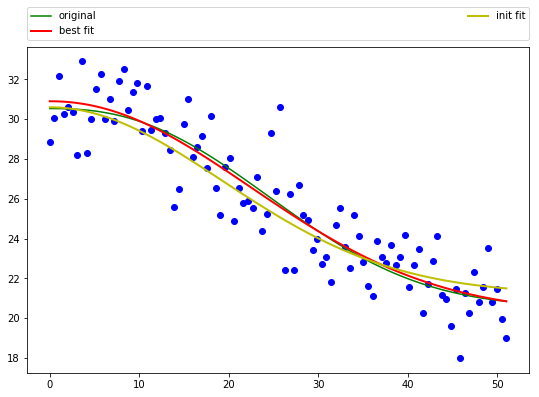

In [18]:
stretchedexponentialdecay_testing()